# Behavioral Profile Stratification via Unsupervised learning

### TODO

> Please report some description here about the pipeline and what I am going to find in the notebook

## Step 1: Data Loading

> Short description here - and notes on Data Accessibility

In [1]:
from dataset import access_db, data_wrangling, cohort_info

In [2]:
# it returns a dictionary of pandas dataframes storing tables from the db
tables = access_db()

In [3]:
# reduced dictionary (it excludes tables and subjects taht are not required, e.g., ados-2modulo4, eas)
rid_tables = data_wrangling(tables)

In [4]:
# it returns dictionary of subjects info and encounters
pinfo, penc = cohort_info(rid_tables)

## Step 2: Feature Processing

> Short description here

In [5]:
from features import DataFeatures

In [6]:
datafeatures = DataFeatures(level=2, df_dict=rid_tables)

In [7]:
behr, (bt_to_idx, idx_to_bt) = datafeatures.create_level_tokens()

---

## Step 3: Embeddings

> Short description here

In [8]:
from pt_embedding import Pembeddings

In [9]:
model = Pembeddings(behr, bt_to_idx)

In [10]:
svd_pid_list, svd_mtx = model.tfidf()

Performing SVD on the TF-IDF matrix...


In [11]:
glove_pid_list, glove_emb, word_emb = model.glove_pemb()


Training Glove embeddings...
epoch 0, error 0.010
epoch 10, error 0.006
epoch 20, error 0.005
epoch 30, error 0.005
epoch 40, error 0.005


---

## Step 4: Clustering

> Short description here

In [12]:
from clustering import HclustEmbeddings, HclustFeatures
import utils as ut

In [13]:
hclust_emb = HclustEmbeddings(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                              affinity='euclidean', linkage='ward')

### `TF-IDF` Embedding

In [14]:
# TFIDF EMBEDDING
# tfidf_best_cl = hclust_emb.find_best_nclu(svd_mtx, n_iter=ut.n_iter, 
#                                           subsampl=ut.subsampl)
tfidf_best_cl = hclust_emb.elbow_method(svd_mtx)

In [15]:
tfidf_subc = hclust_emb.fit(svd_mtx, svd_pid_list, tfidf_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.16
Cluster 0 -- Numerosity 132
Cluster 1 -- Numerosity 73






### `Glove` Embedding

In [16]:
# GLOVE EMBEDDING
# glv_best_cl = hclust_emb.find_best_nclu(glove_emb, n_iter=ut.n_iter, subsampl=ut.subsampl)
glv_best_cl = hclust_emb.elbow_method(glove_emb)

In [17]:
glv_subc = hclust_emb.fit(glove_emb, glove_pid_list, glv_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.53
Cluster 0 -- Numerosity 197
Cluster 1 -- Numerosity 8






## Step 5: Clustering II (Visualization) 

> Short description here

In [18]:
from visualization import Visualization

In [19]:
viz = Visualization(pinfo, ut.col_dict, ut.c_out)

In [20]:
# Example of visualization for tfidf embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(svd_mtx, tfidf_subc, svd_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

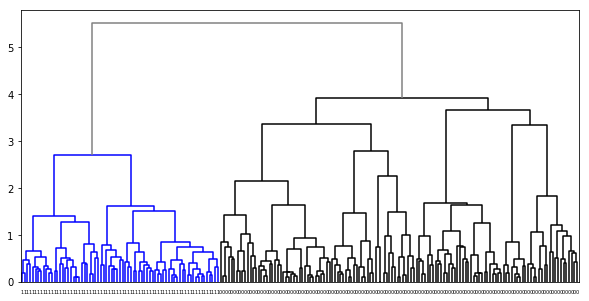

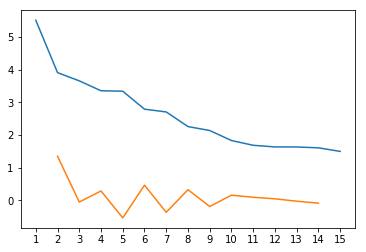

In [21]:
viz.scatterplot_dendrogram(svd_mtx, umap_mtx, pid_subc_list, 10, 5)

In [22]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, tfidf_subc)

In [23]:
viz.heatmap_emb(emb_scaled, 400, 1000)

In [24]:
# Example of visualization for GloVe embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(glove_emb, glv_subc, glove_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

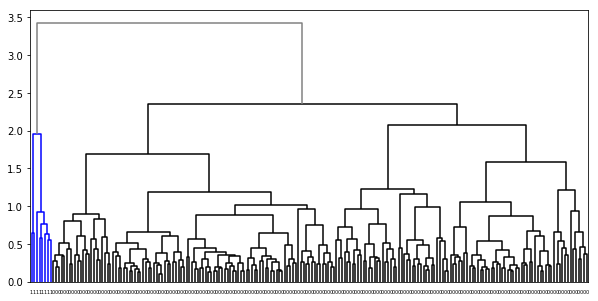

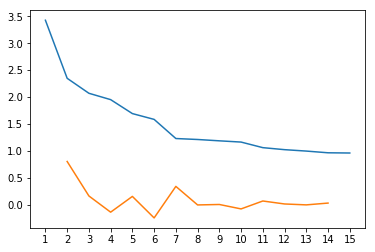

In [25]:
viz.scatterplot_dendrogram(glove_emb, umap_mtx, pid_subc_list, 10, 5)

In [26]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, glv_subc)

In [27]:
viz.heatmap_emb(emb_scaled, 800, 800)